# This notebook shows the training of RFCX data on Tensorflow TPU

The dataset used in this notebook is 10 fold Groupkfold tp only tfrecords that i have created [here](http://www.kaggle.com/ashusma/rfcx-audio-detection) and the simple script for the notebook is [this](https://www.kaggle.com/ashusma/rfcx-audio-creating-tfrecords?scriptVersionId=51531240).

Training description :

* training with 10 sec clip around true positives
* taking full spectrogram size 
* random augmentation and gaussian noise
* label smoothing
* stepwise cosine decay with warm restarts and early stopping
* for inference 10sec clip is used and then aggregrating and taking max of the audio wav prediction 


Since this notebook uses tpu accelerator having 128 gb (16 gb each replica) so for efficient use i have done following optimization :
* increased the spectrogram size
* caching validation and test set as both are small in number for faster computation
* wrapped all user defined function with map that allow parallel computation
* reduced the python overhead 
* tensorflow 2.3 and above has argument execution per step in model.compile function that significantly improves performance by running multiple steps within tpu worker. but since kaggle has not updated tf version we cannot take advantage of that but one can try it on google colab
* above step can also be done by using custom training loop

In [1]:
! pip install -q efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import math, os, re, warnings, random
import tensorflow as tf
import numpy as np
import pandas as pd
import librosa
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from IPython.display import Audio
from tensorflow.keras import Model, layers
from sklearn.model_selection import KFold
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, Dropout, GaussianNoise
from tensorflow.keras.applications import ResNet50
import efficientnet.keras as efn
import seaborn as sns

# TPU Detection And Initialization

In [3]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.0.0.2:8470
REPLICAS: 8


In [4]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 42
seed_everything(seed)
warnings.filterwarnings('ignore')

In [5]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# train_files

TRAIN_DATA_DIR = 'rfcx-audio-detection'
TRAIN_GCS_PATH = KaggleDatasets().get_gcs_path(TRAIN_DATA_DIR)
FILENAMES = tf.io.gfile.glob(TRAIN_GCS_PATH + '/tp*.tfrec')


#test_files
TEST_DATA_DIR = 'rfcx-species-audio-detection'
TEST_GCS_PATH =  KaggleDatasets().get_gcs_path(TEST_DATA_DIR)
TEST_FILES = tf.io.gfile.glob(TEST_GCS_PATH + '/tfrecords/test/*.tfrec')

no_of_training_samples = count_data_items(FILENAMES)

print('num_training_samples are', no_of_training_samples)

num_training_samples are 1216


In [6]:
CUT = 10
TIME = 10
EPOCHS = 25
GLOBAL_BATCH_SIZE = 4 * REPLICAS
LEARNING_RATE = 0.0015
WARMUP_LEARNING_RATE = 1e-5
WARMUP_EPOCHS = int(EPOCHS*0.1)
PATIENCE = 8
STEPS_PER_EPOCH = 64
N_FOLDS = 5
NUM_TRAINING_SAMPLES = no_of_training_samples


class params:
    sample_rate = 48000
    stft_window_seconds: float = 0.025
    stft_hop_seconds: float = 0.005
    frame_length: int =  1200    
    mel_bands: int = 512
    mel_min_hz: float = 50.0
    mel_max_hz: float = 24000.0
    log_offset: float = 0.001
    patch_window_seconds: float = 0.96
    patch_hop_seconds: float = 0.48

  
    patch_frames =  int(round(patch_window_seconds / stft_hop_seconds))

  
    patch_bands = mel_bands
    height = mel_bands
    width = 2000
    num_classes: int = 24
    dropout = 0.35
    classifier_activation: str = 'sigmoid'


In [7]:
feature_description = {
    'wav': tf.io.FixedLenFeature([], tf.string),
    'recording_id': tf.io.FixedLenFeature([], tf.string ),
    'target' : tf.io.FixedLenFeature([], tf.float32),
    'song_id': tf.io.FixedLenFeature([], tf.float32),
     'tmin' : tf.io.FixedLenFeature([], tf.float32),
     'fmin' : tf.io.FixedLenFeature([], tf.float32),
     'tmax' : tf.io.FixedLenFeature([], tf.float32),
     'fmax' : tf.io.FixedLenFeature([], tf.float32),
}
feature_dtype = {
    'wav': tf.float32,
    'recording_id': tf.string,
    'target': tf.float32,
    'song_id': tf.float32,
    't_min': tf.float32,
    'f_min': tf.float32,
    't_max': tf.float32,
    'f_max':tf.float32,
}

In [8]:
def waveform_to_log_mel_spectrogram(waveform,target_or_rec_id):
    """Compute log mel spectrogram patches of a 1-D waveform."""
    # waveform has shape [<# samples>]

    # Convert waveform into spectrogram using a Short-Time Fourier Transform.
    # Note that tf.signal.stft() uses a periodic Hann window by default.

    window_length_samples = int(
      round(params.sample_rate * params.stft_window_seconds))
    hop_length_samples = int(
      round(params.sample_rate * params.stft_hop_seconds))
    fft_length = 2 ** int(np.ceil(np.log(window_length_samples) / np.log(2.0)))
#     print(fft_length, window_length_samples, hop_length_samples)
    num_spectrogram_bins = fft_length // 2 + 1
    magnitude_spectrogram = tf.abs(tf.signal.stft(
      signals=waveform,
      frame_length=params.frame_length,
      frame_step=hop_length_samples,
      fft_length= fft_length))
    # magnitude_spectrogram has shape [<# STFT frames>, num_spectrogram_bins]

    # Convert spectrogram into log mel spectrogram.
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=params.mel_bands,
        num_spectrogram_bins=num_spectrogram_bins,
        sample_rate=params.sample_rate,
        lower_edge_hertz=params.mel_min_hz,
        upper_edge_hertz=params.mel_max_hz)
    mel_spectrogram = tf.matmul(
      magnitude_spectrogram, linear_to_mel_weight_matrix)
    log_mel = tf.math.log(mel_spectrogram + params.log_offset)
#     log_mel_spectrogram has shape [<# STFT frames>, params.mel_bands]
    log_mel = tf.transpose(log_mel)
    log_mel_spectrogram = tf.reshape(log_mel , [tf.shape(log_mel)[0] ,tf.shape(log_mel)[1],1])
    # Frame spectrogram (shape [<# STFT frames>, params.mel_bands]) into patches
    # (the input examples). Only complete frames are emitted, so if there is
    # less than params.patch_window_seconds of waveform then nothing is emitted
    # (to avoid this, zero-pad before processing).
    spectrogram_hop_length_samples = int(
      round(params.sample_rate * params.stft_hop_seconds))
    spectrogram_sample_rate = params.sample_rate / spectrogram_hop_length_samples
    patch_window_length_samples = int(
      round(spectrogram_sample_rate * params.patch_window_seconds))
    patch_hop_length_samples = int(
      round(spectrogram_sample_rate * params.patch_hop_seconds))
    features = tf.signal.frame(
        signal=log_mel_spectrogram,
        frame_length=patch_window_length_samples,
        frame_step=patch_hop_length_samples,
        axis=0)
    # features has shape [<# patches>, <# STFT frames in an patch>, params.mel_bands]
    
    return log_mel_spectrogram, target_or_rec_id

# Data augmentation

In [9]:
def frequency_masking(mel_spectrogram):
    
    frequency_masking_para = 80, 
    frequency_mask_num = 2
    
    fbank_size = tf.shape(mel_spectrogram)
#     print(fbank_size)
    n, v = fbank_size[0], fbank_size[1]

    for i in range(frequency_mask_num):
        f = tf.random.uniform([], minval=0, maxval= tf.squeeze(frequency_masking_para), dtype=tf.int32)
        v = tf.cast(v, dtype=tf.int32)
        f0 = tf.random.uniform([], minval=0, maxval= tf.squeeze(v-f), dtype=tf.int32)

        # warped_mel_spectrogram[f0:f0 + f, :] = 0
        mask = tf.concat((tf.ones(shape=(n, v - f0 - f,1)),
                          tf.zeros(shape=(n, f,1)),
                          tf.ones(shape=(n, f0,1)),
                          ),1)
        mel_spectrogram = mel_spectrogram * mask
    return tf.cast(mel_spectrogram, dtype=tf.float32)


def time_masking(mel_spectrogram):
    time_masking_para = 40, 
    time_mask_num = 1
    
    fbank_size = tf.shape(mel_spectrogram)
    n, v = fbank_size[0], fbank_size[1]

   
    for i in range(time_mask_num):
        t = tf.random.uniform([], minval=0, maxval=tf.squeeze(time_masking_para), dtype=tf.int32)
        t0 = tf.random.uniform([], minval=0, maxval= n-t, dtype=tf.int32)

        # mel_spectrogram[:, t0:t0 + t] = 0
        mask = tf.concat((tf.ones(shape=(n-t0-t, v,1)),
                          tf.zeros(shape=(t, v,1)),
                          tf.ones(shape=(t0, v,1)),
                          ), 0)
        
        mel_spectrogram = mel_spectrogram * mask
    return tf.cast(mel_spectrogram, dtype=tf.float32)


def random_brightness(image):
    return tf.image.random_brightness(image, 0.2)

def random_gamma(image):
    return tf.image.random_contrast(image, lower = 0.1, upper = 0.3)

def random_flip_right(image):
    return tf.image.random_flip_left_right(image)

def random_flip_up_down(image):
    return tf.image.random_flip_left_right(image)

available_ops = [
          frequency_masking ,
          time_masking, 
          random_brightness, 
          random_flip_up_down,
          random_flip_right 
         ]

def apply_augmentation(image, target):
    num_layers = int(np.random.uniform(low = 0, high = 3))
    
    for layer_num in range(num_layers):
        op_to_select = tf.random.uniform([], maxval=len(available_ops), dtype=tf.int32, seed = seed)
        for (i, op_name) in enumerate(available_ops):
            image = tf.cond(
            tf.equal(i, op_to_select),
            lambda selected_func=op_name,: selected_func(
                image),
            lambda: image)
    return image, target

# Training Data Pipeline

In [10]:
def preprocess(image, target_or_rec_id):
    
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image, [params.height,params.width])
    image = tf.image.per_image_standardization(image)
    return image , target_or_rec_id


def read_labeled_tfrecord(example_proto):
    sample = tf.io.parse_single_example(example_proto, feature_description)
    wav, _ = tf.audio.decode_wav(sample['wav'], desired_channels=1) # mono
    target = tf.cast(sample['target'],tf.float32)
    target = tf.squeeze(tf.one_hot([target,], depth = params.num_classes), axis = 0)
    
    tmin = tf.cast(sample['tmin'], tf.float32)
    fmin = tf.cast(sample['fmin'], tf.float32)
    tmax = tf.cast(sample['tmax'], tf.float32)
    fmax = tf.cast(sample['fmax'], tf.float32)
    
    tmax_s = tmax * tf.cast(params.sample_rate, tf.float32)
    tmin_s = tmin * tf.cast(params.sample_rate, tf.float32)
    cut_s = tf.cast(CUT * params.sample_rate, tf.float32)
    all_s = tf.cast(60 * params.sample_rate, tf.float32)
    tsize_s = tmax_s - tmin_s
    cut_min = tf.cast(
    tf.maximum(0.0, 
        tf.minimum(tmin_s - (cut_s - tsize_s) / 2,
                   tf.minimum(tmax_s + (cut_s - tsize_s) / 2, all_s) - cut_s)
    ), tf.int32
      )
    cut_max = cut_min + CUT * params.sample_rate
    wav = tf.squeeze(wav[cut_min : cut_max] )
    
    return wav, target

def read_unlabeled_tfrecord(example):
    feature_description = {
    'recording_id': tf.io.FixedLenFeature([], tf.string),
    'audio_wav': tf.io.FixedLenFeature([], tf.string),
    }
    sample = tf.io.parse_single_example(example, feature_description)
    wav, _ = tf.audio.decode_wav(sample['audio_wav'], desired_channels=1) # mono
    recording_id = tf.reshape(tf.cast(sample['recording_id'] , tf.string), [1])
#     wav = tf.squeeze(wav)

    def _cut_audio(i):
        _sample = {
            'audio_wav': tf.reshape(wav[i*params.sample_rate*TIME:(i+1)*params.sample_rate*TIME], [params.sample_rate*TIME]),
            'recording_id': sample['recording_id']
        }
        return _sample

    return tf.map_fn(_cut_audio, tf.range(60//TIME), dtype={
        'audio_wav': tf.float32,
        'recording_id': tf.string
    })

In [11]:
def load_dataset(filenames, labeled = True, ordered = False , training = True):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # Diregarding data order. Order does not matter since we will be shuffling the data anyway
    
    ignore_order = tf.data.Options()
    if not ordered:
        # disable order, increase speed
        ignore_order.experimental_deterministic = False 
        
    # automatically interleaves reads from multiple files
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO )
    # use data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord , num_parallel_calls = AUTO )
    dataset = dataset.map(waveform_to_log_mel_spectrogram , num_parallel_calls = AUTO)   
    if training:
        dataset = dataset.map(apply_augmentation, num_parallel_calls = AUTO)
    dataset = dataset.map(preprocess, num_parallel_calls = AUTO)
    return dataset

In [12]:
def get_dataset(filenames, training = True):
    if training:
        dataset = load_dataset(filenames , training = True)
        dataset = dataset.shuffle(256).repeat()
        dataset = dataset.batch(GLOBAL_BATCH_SIZE, drop_remainder = True)
    else:
        dataset = load_dataset(filenames , training = False)
        dataset = dataset.batch(GLOBAL_BATCH_SIZE).cache()
    
    dataset = dataset.prefetch(AUTO)
    return dataset

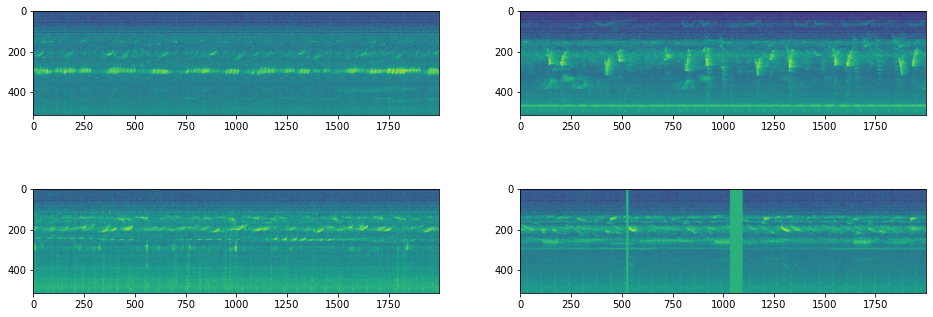

In [13]:
# mel spectrogram visualization

train_dataset = get_dataset(FILENAMES, training = True)

plt.figure(figsize=(16,6))
for i, (wav, target) in enumerate(train_dataset.unbatch().take(4)):
    plt.subplot(2,2,i+1)
    plt.imshow(wav[:, :, 0])
plt.show()

# Competition Metric

In [14]:
# from https://www.kaggle.com/carlthome/l-lrap-metric-for-tf-keras

def _one_sample_positive_class_precisions(example):
    y_true, y_pred = example
    y_true = tf.reshape(y_true, tf.shape(y_pred))
    retrieved_classes = tf.argsort(y_pred, direction='DESCENDING')
#     shape = tf.shape(retrieved_classes)
    class_rankings = tf.argsort(retrieved_classes)
    retrieved_class_true = tf.gather(y_true, retrieved_classes)
    retrieved_cumulative_hits = tf.math.cumsum(tf.cast(retrieved_class_true, tf.float32))

    idx = tf.where(y_true)[:, 0]
    i = tf.boolean_mask(class_rankings, y_true)
    r = tf.gather(retrieved_cumulative_hits, i)
    c = 1 + tf.cast(i, tf.float32)
    precisions = r / c

    dense = tf.scatter_nd(idx[:, None], precisions, [y_pred.shape[0]])
    return dense

# @tf.function
class LWLRAP(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='lwlrap'):
        super().__init__(name=name)

        self._precisions = self.add_weight(
            name='per_class_cumulative_precision',
            shape=[num_classes],
            initializer='zeros',
        )

        self._counts = self.add_weight(
            name='per_class_cumulative_count',
            shape=[num_classes],
            initializer='zeros',
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        precisions = tf.map_fn(
            fn=_one_sample_positive_class_precisions,
            elems=(y_true, y_pred),
            dtype=(tf.float32),
        )

        increments = tf.cast(precisions > 0, tf.float32)
        total_increments = tf.reduce_sum(increments, axis=0)
        total_precisions = tf.reduce_sum(precisions, axis=0)

        self._precisions.assign_add(total_precisions)
        self._counts.assign_add(total_increments)        

    def result(self):
        per_class_lwlrap = self._precisions / tf.maximum(self._counts, 1.0)
        per_class_weight = self._counts / tf.reduce_sum(self._counts)
        overall_lwlrap = tf.reduce_sum(per_class_lwlrap * per_class_weight)
        return overall_lwlrap

    def reset_states(self):
        self._precisions.assign(self._precisions * 0)
        self._counts.assign(self._counts * 0)

# Stepwise Cosine Decay Callback

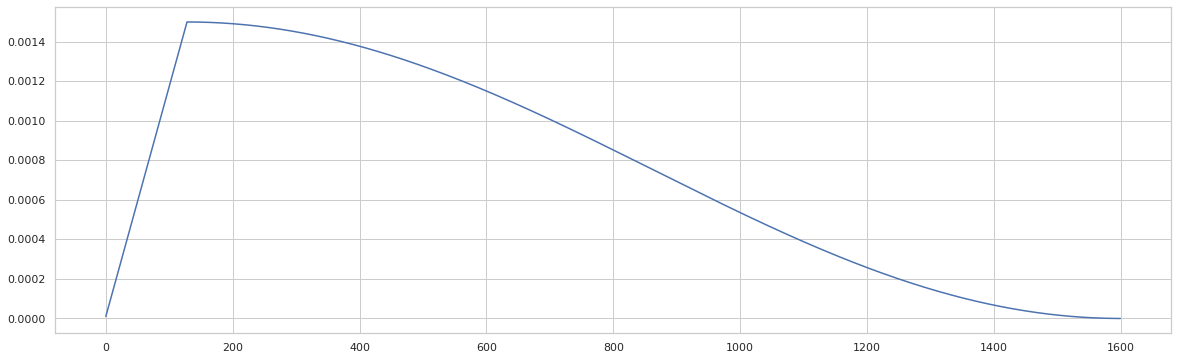

In [15]:
def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps= 0,
                             hold_base_rate_steps=0):
 
    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to '
                     'warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + tf.cos(
        np.pi *
        (tf.cast(global_step, tf.float32) - warmup_steps - hold_base_rate_steps
        ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = tf.where(
          global_step > warmup_steps + hold_base_rate_steps,
          learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to '
                         'warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * tf.cast(global_step,
                                    tf.float32) + warmup_learning_rate
        learning_rate = tf.where(global_step < warmup_steps, warmup_rate,
                               learning_rate)
    return tf.where(global_step > total_steps, 0.0, learning_rate,
                    name='learning_rate')


#dummy example
rng = [i for i in range(int(EPOCHS * STEPS_PER_EPOCH))]
WARMUP_STEPS =  int(WARMUP_EPOCHS * STEPS_PER_EPOCH)
y = [cosine_decay_with_warmup(x , LEARNING_RATE, len(rng), 1e-5, WARMUP_STEPS) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [16]:
# to apply learning rate schedule stepwise we need to subclass keras callback
# if we would have applied lr schedule epoch wise then it is not needed we can only call class learningrateschedule 

class WarmUpCosineDecayScheduler(tf.keras.callbacks.Callback):

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_step + 1, lr.numpy()))
            

total_steps = int(EPOCHS * STEPS_PER_EPOCH)
# Compute the number of warmup batches or steps.
warmup_steps = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)
warmup_learning_rate = WARMUP_LEARNING_RATE

# Model Definition

In [17]:
def RFCX_MODEL():
    waveform = Input(shape=(None,None,3), dtype=tf.float32)
    noisy_waveform = GaussianNoise(0.2)(waveform)
    model = efn.EfficientNetB2(include_top=False, weights='imagenet',) 
    model_output = model(noisy_waveform)
    model_output = GlobalAveragePooling2D()(model_output)
    dense = Dropout(params.dropout)(model_output)
    predictions = Dense(params.num_classes, activation = params.classifier_activation )(dense)
    model = Model(
      name='Efficientnet', inputs=waveform,
      outputs=[predictions])
    return model

In [18]:
def get_model():
    with strategy.scope():
        model = RFCX_MODEL()
        model.summary()
        model.compile(optimizer = 'adam',
                                loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.1),
                                metrics = [LWLRAP(num_classes = params.num_classes),
                                ])
    return model

# Training And Validation Loop

In [19]:
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; history_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(10))):
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # Create train and validation sets
    TRAIN_FILENAMES = [FILENAMES[x] for x in idxT]
    VALID_FILENAMES = [FILENAMES[x] for x in idxV]
    np.random.shuffle(TRAIN_FILENAMES)
    
    train_dataset =  get_dataset(TRAIN_FILENAMES, training=True,)
    validation_data= get_dataset(VALID_FILENAMES, training=False) 

    model = get_model()

    model_path = f'RFCX_model_fold {fold}.h5'
    early_stopping = EarlyStopping(monitor = 'val_lwlrap', mode = 'max', 
                       patience = PATIENCE, restore_best_weights=True, verbose=1)

    # Create the Learning rate scheduler.
    cosine_warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base= LEARNING_RATE,
                                    total_steps= total_steps,
                                    warmup_learning_rate= warmup_learning_rate,
                                    warmup_steps= warmup_steps,
                                    hold_base_rate_steps=0)

    ## TRAIN
    history = model.fit(train_dataset, 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        callbacks=[early_stopping, cosine_warm_up_lr], 
                        epochs=EPOCHS,  
                        validation_data = validation_data,
                        verbose = 2).history

    history_list.append(history)
    # Save last model weights
    model.save_weights(model_path)

# OOF predictions
    ds_valid = get_dataset(VALID_FILENAMES, training = False)
    oof_labels.append([target.numpy() for frame, target in iter(ds_valid.unbatch())])
    x_oof = ds_valid.map(lambda frames, target: frames)
    oof_pred.append(np.argmax(model.predict(x_oof), axis=-1))

    ## RESULTS
    print(f"#### FOLD {fold+1} OOF Accuracy = {np.max(history['val_lwlrap']):.3f}")


FOLD: 1
TRAIN: [0 2 3 4 5 6 7 9] VALID: [1 8]
31940608/31936256 [==============================] - 2s 0us/step
Model: "Efficientnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, None, None, 3)     0         
_________________________________________________________________
efficientnet-b2 (Model)      (None, None, None, 1408)  7768562   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 24)                33816     
Total pa

# Plot curve

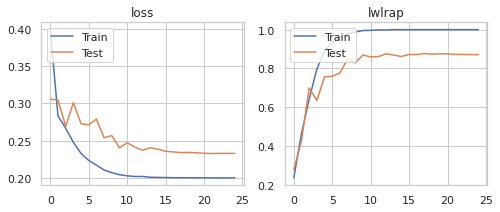

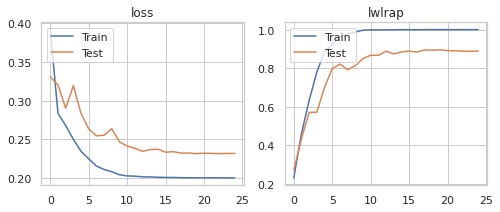

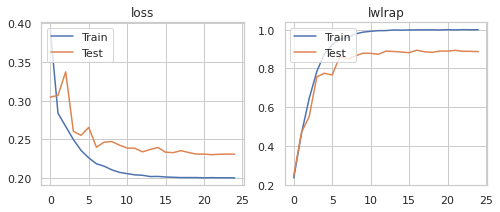

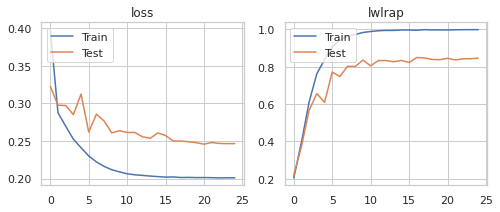

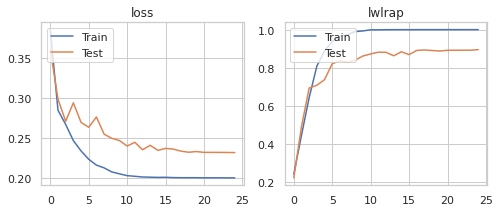

In [20]:
def plot_history(history):
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.plot(history["loss"])
    plt.plot(history["val_loss"])
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.title("loss")

    plt.subplot(1,2,2)
    plt.plot(history["lwlrap"])
    plt.plot(history["val_lwlrap"])
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.title("lwlrap")
    
for hist in history_list:
    plot_history(hist)

# Inference

In [21]:
def get_test_dataset(filenames, training = False):
    
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO )  
    dataset = dataset.map(read_unlabeled_tfrecord , num_parallel_calls = AUTO ).unbatch()
    dataset = dataset.map(lambda spec : waveform_to_log_mel_spectrogram(spec['audio_wav'], spec['recording_id']) , num_parallel_calls = AUTO)
    dataset = dataset.map(preprocess, num_parallel_calls = AUTO)
    return dataset.batch(GLOBAL_BATCH_SIZE*4).cache()

In [22]:
test_predict = []

test_data = get_test_dataset(TEST_FILES, training = False)
test_audio = test_data.map(lambda frames, recording_id: frames)

for fold in range(N_FOLDS):
    model.load_weights(f'./RFCX_model_fold {fold}.h5')
    test_predict.append(model.predict(test_audio, verbose = 1 ))

94/94 [==============================] - 39s 416ms/step


# Submission

In [23]:
np.array(test_predict).shape

(5, 11952, 24)

In [24]:
SUB = pd.read_csv('../input/rfcx-species-audio-detection/sample_submission.csv')

predict = np.array(test_predict).reshape(N_FOLDS, len(SUB), 60 // TIME, params.num_classes)
predict = np.mean(np.max(predict ,axis = 2) , axis = 0)
# predict = np.mean(predict, axis =  0)

recording_id = test_data.map(lambda frames, recording_id: recording_id).unbatch()
# # all in one batch
test_ids = next(iter(recording_id.batch(len(SUB) * 60 // TIME))).numpy().astype('U').reshape(len(SUB), 60 // TIME)

pred_df = pd.DataFrame({ 'recording_id' : test_ids[:, 0],
             **{f's{i}' : predict[:, i] for i in range(params.num_classes)} })

In [25]:
pred_df.sort_values('recording_id', inplace = True) 
pred_df.to_csv('submission.csv', index = False)    

In [26]:
pred_df

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,000316da7,0.064478,0.077867,0.061001,0.900531,0.092453,0.067719,0.083469,0.100483,0.058810,...,0.059122,0.121498,0.076909,0.207109,0.175263,0.055255,0.143623,0.137626,0.064244,0.588649
32,003bc2cb2,0.040720,0.046613,0.046107,0.115369,0.046783,0.048467,0.060647,0.052762,0.043807,...,0.045739,0.046474,0.990400,0.044977,0.048458,0.046435,0.045036,0.041829,0.045568,0.054821
64,0061c037e,0.152087,0.063591,0.077135,0.385517,0.079860,0.213214,0.065843,0.723094,0.079710,...,0.136532,0.066142,0.077149,0.077495,0.068273,0.052989,0.090156,0.075640,0.107509,0.141502
96,010eb14d3,0.962930,0.033194,0.044012,0.047191,0.042139,0.058357,0.043953,0.047714,0.328993,...,0.034897,0.045996,0.044388,0.047552,0.149205,0.043113,0.049028,0.044260,0.046851,0.044403
128,011318064,0.047873,0.048189,0.051123,0.547272,0.046555,0.054145,0.052897,0.054953,0.054252,...,0.974366,0.357561,0.068629,0.064519,0.560604,0.047821,0.056469,0.047903,0.051945,0.051355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,ff68f3ac3,0.073262,0.050557,0.057655,0.239713,0.054878,0.881876,0.052771,0.280914,0.050522,...,0.049046,0.905612,0.051654,0.050241,0.049002,0.054880,0.075496,0.053382,0.052394,0.949760
1151,ff973e852,0.052483,0.052631,0.051936,0.051545,0.051859,0.102557,0.049150,0.949516,0.053204,...,0.060952,0.650046,0.046478,0.369304,0.048868,0.050091,0.117963,0.048965,0.071664,0.090948
1183,ffa5cf6d6,0.062393,0.222523,0.083916,0.581710,0.063623,0.235306,0.065999,0.561232,0.055144,...,0.074198,0.978872,0.068977,0.188426,0.049837,0.056444,0.090514,0.070250,0.085493,0.084761
1215,ffa88cbb8,0.067814,0.130323,0.062958,0.961310,0.052219,0.220686,0.054750,0.925787,0.052297,...,0.052232,0.053858,0.329646,0.054852,0.046993,0.051598,0.054817,0.073046,0.062077,0.243836
